<a href="https://colab.research.google.com/github/Aztol/UNIL---Kaggle-DS-ML-competition/blob/main/best_run_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip3 install tokenizer
!pip3 install sentencepiece
#!pip3 install googletrans
!pip3 install deep-translator
import pandas as pd
import torch
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AdamW
from transformers import CamembertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import DataLoader, SequentialSampler, TensorDataset
from transformers import CamembertForSequenceClassification, CamembertTokenizer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange
import nltk
import tokenizer as tokenizer_2
import re
from nltk.tokenize import word_tokenize
import string
#from googletrans import Translator, LANGUAGES
from deep_translator import GoogleTranslator



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.7 MB/s eta 0:00:00


In [ ]:


df = pd.read_csv('training_data.csv').reset_index(drop=True)
df.head()
print(df.shape)


# Initialize the translator
i=0
def translate_sentence_deep(sentence, src_lang, intermediate_lang):
    # Translate to the intermediate language (Portuguese)
    translated_to_intermediate = GoogleTranslator(source=src_lang, target=intermediate_lang).translate(sentence)
    # Translate back to the source language (French)
    return GoogleTranslator(source=intermediate_lang, target=src_lang).translate(translated_to_intermediate)

def translate_sentences_deep(df):
    translated_sentences = []
    i = 0
    for _, row in df.iterrows():

        translated_sentence = translate_sentence_deep(row['sentence'], 'fr', 'pt')
        translated_sentences.append({'id': row['id'], 'sentence': translated_sentence, 'difficulty': row['difficulty']})
        i = i+1
        print(i)
    translated_df = pd.DataFrame(translated_sentences)
    return pd.concat([df, translated_df], ignore_index=True)




translated_df = pd.DataFrame()
df = translate_sentences_deep(df)
print(df.shape)

NameError: ignored

In [3]:
df = pd.read_csv('training_data.csv').reset_index(drop=True)
df = df.drop_duplicates(subset=['sentence'])
print(df.shape)

(4800, 3)


In [4]:



epochs = 8
MAX_LEN = 128
batch_size = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the dataset, I selected only 5000 sample because of memory limitation
#df = pd.read_csv('training_data.csv').reset_index(drop=True)
#df.head()
true_labels = []
predictions = []
# Mapping des valeurs de la colonne "difficulty"
difficulty_mapping = {
    'A1': 0,
    'A2': 1,
    'B1': 2,
    'B2': 3,
    'C1': 4,
    'C2': 5
}

# Utiliser la fonction map pour encoder les valeurs
df['difficulty_encoded'] = df['difficulty'].map(difficulty_mapping)

unique_labels = df['difficulty_encoded'].unique()
print(unique_labels)

# Creates list of texts and labels
text = df['sentence'].to_list()
labels = df['difficulty_encoded'].to_list()  # Utilisez les labels encodés

# Utilisez le tokenizer Camembert
tokenizer = CamembertTokenizer.from_pretrained("camembert-base", do_lower_case=True)


# Utilisez le tokenizer pour convertir les phrases en tokens
input_ids = [tokenizer.encode(sent, add_special_tokens=True, max_length=MAX_LEN, pad_to_max_length=True, truncation=True) for sent in text]

# Créez des masques d'attention
attention_masks = []
# Créez un masque de 1 pour chaque token suivi de 0 pour le padding
for seq in input_ids:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks.append(seq_mask)

    # Convertissez les listes en tenseurs PyTorch
input_ids = torch.tensor(input_ids)
attention_masks = torch.tensor(attention_masks)
labels = torch.tensor(labels)

# Créez un DataLoader pour gérer les lots de données
dataset = TensorDataset(input_ids, attention_masks, labels)
dataloader = DataLoader(dataset, batch_size=batch_size, sampler=RandomSampler(dataset))

# Vous pouvez maintenant utiliser dataloader pour l'entraînement de votre modèle.
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
                                                            random_state=42, test_size=0.2)


# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs).to(device)
validation_inputs = torch.tensor(validation_inputs).to(device)
train_labels = torch.tensor(train_labels).to(device)
validation_labels = torch.tensor(validation_labels).to(device)
train_masks = torch.tensor(train_masks).to(device)
validation_masks = torch.tensor(validation_masks).to(device)


# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=6)
model.to(device)


param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
from transformers import AdamW
from sklearn.metrics import accuracy_score

# Define the optimizer and set the learning rate
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9) --> Not good
#optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8) #--> Best
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99) --> null
#optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
#optimizer = AdamW(model.parameters(), lr=4e-05, eps=1e-08) #--> Best
optimizer = AdamW(model.parameters(), lr=4e-05, eps=1e-08) #--> Best
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, pred_flat)


# Store our loss and accuracy for plotting if we want to visualize training evolution per epochs after the training process
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
    # Tracking variables for training
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    # Train the model
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Add batch to device CPU or GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # Get loss value
        loss = outputs.loss
        # Add it to train loss list
        train_loss_set.append(loss.item())
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
# Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))

    # Tracking variables for validation
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Validation of the model
    model.eval()
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to device CPU or GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs =  model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            logits = outputs.logits

        # Move logits and labels to CPU if GPU is used
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # for calculating metrics
        true_labels.append(label_ids)
        predictions.append(np.argmax(logits, axis=1))

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))



[4 0 2 1 3 5]


sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
<ipython-input-4-2ef5f11113e1>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(train_inputs).to(device)
<ipython-input-4-2ef5f11113e1>:62: UserWarning: To copy construct fr

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Train loss: 1.7362187271316847


Epoch:  12%|█▎        | 1/8 [00:33<03:52, 33.16s/it]

Validation Accuracy: 0.25625
Train loss: 1.2813251321514447


Epoch:  25%|██▌       | 2/8 [01:04<03:12, 32.07s/it]

Validation Accuracy: 0.5
Train loss: 1.0669643009702365


Epoch:  38%|███▊      | 3/8 [01:33<02:32, 30.49s/it]

Validation Accuracy: 0.5052083333333334
Train loss: 0.8676768250763416


Epoch:  50%|█████     | 4/8 [02:03<02:01, 30.34s/it]

Validation Accuracy: 0.5489583333333333
Train loss: 0.6287361167371273


Epoch:  62%|██████▎   | 5/8 [02:31<01:29, 29.73s/it]

Validation Accuracy: 0.5645833333333333
Train loss: 0.4583391261597474


Epoch:  75%|███████▌  | 6/8 [03:00<00:59, 29.52s/it]

Validation Accuracy: 0.5510416666666667
Train loss: 0.30737642062207066


Epoch:  88%|████████▊ | 7/8 [03:29<00:29, 29.23s/it]

Validation Accuracy: 0.56875
Train loss: 0.20291315992362796


Epoch: 100%|██████████| 8/8 [03:58<00:00, 29.79s/it]

Validation Accuracy: 0.5604166666666667


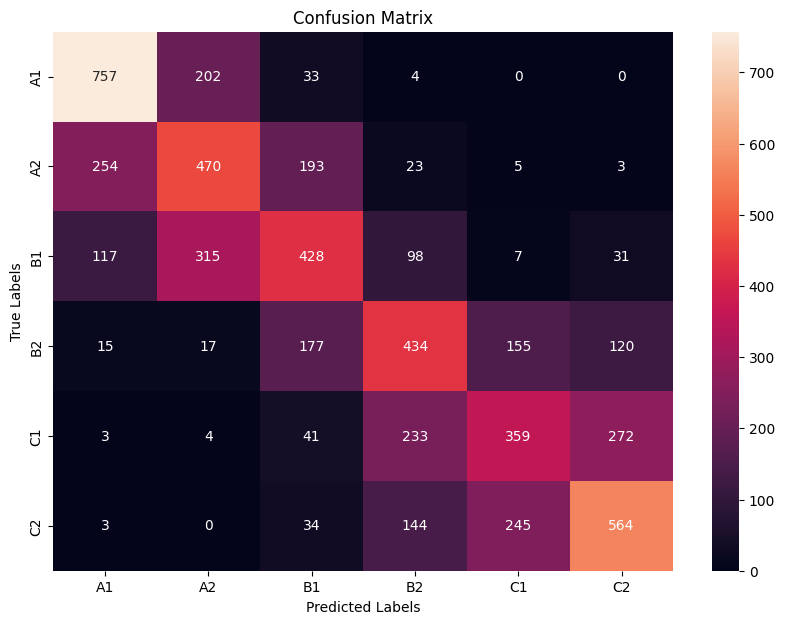

Precision: 0.5178899899110185
Recall: 0.5229166666666667
F1 Score: 0.5190455625744844


In [5]:
true_labels = np.concatenate(true_labels).flatten()
predictions = np.concatenate(predictions).flatten()

precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

predicted_label_names = [list(difficulty_mapping.keys())[list(difficulty_mapping.values()).index(label)] for label in predictions]

# Convert true labels to the same format as predictions for consistency
true_label_names = [list(difficulty_mapping.keys())[list(difficulty_mapping.values()).index(label)] for label in true_labels]

# Generate confusion matrix
cm = confusion_matrix(true_label_names, predicted_label_names, labels=list(difficulty_mapping.keys()))



plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', xticklabels=difficulty_mapping.keys(), yticklabels=difficulty_mapping.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

In [5]:
# Charger le nouveau jeu de données
# Remplacez 'new_data.csv' par le chemin de votre fichier de nouvelles phrases
new_df = pd.read_csv('unlabelled_test_data.csv')
new_texts = new_df['sentence'].tolist()  # Assurez-vous que la colonne contient les phrases

# Préparer les données pour le modèle
tokenizer = CamembertTokenizer.from_pretrained('camembert-base', do_lower_case=True)
new_input_ids = [tokenizer.encode(sent, add_special_tokens=True, max_length=MAX_LEN, pad_to_max_length=True, truncation=True) for sent in new_texts]
new_attention_masks = [[float(i > 0) for i in seq] for seq in new_input_ids]

# Convertir en tenseurs
new_input_ids = torch.tensor(new_input_ids)

new_attention_masks = torch.tensor(new_attention_masks)

# Créer un DataLoader
prediction_data = TensorDataset(new_input_ids, new_attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Prédiction
model.eval()
predictions = []

for batch in prediction_dataloader:
    # Ajouter batch à GPU
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask = batch

    with torch.no_grad():
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)

# Convertir les prédictions en étiquettes de difficulté
predicted_labels = [np.argmax(p, axis=1).flatten() for p in predictions]
predicted_labels = np.concatenate(predicted_labels)

# Créer un DataFrame pour le CSV
output_df = pd.DataFrame({
    'id': new_df.index,  # ou une autre colonne d'identification si disponible
    'difficulty': [list(difficulty_mapping.keys())[list(difficulty_mapping.values()).index(label)] for label in predicted_labels]
})

# Enregistrer en CSV
output_df.to_csv('predicted_difficulties26.csv', index=False)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
torch.save(model.state_dict(), "model_weights.pt")
model.config.to_json_file("model_config.json")
tokenizer.save_pretrained("tokenizer/")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/sentencepiece.bpe.model',
 'tokenizer/added_tokens.json')

# Nouvelle section